# Trees, Bagging and Boosting

This lab illustrates one learning algorithm used to build decision trees and two learning meta-algorithms, the _bagging_ and the _boosting_.

<font color='red'>For pedagogical reasons, we code these models _almost_ from scratch, however these models are already implemented in `sklearn`. Outside of this lab, one should use the `sklearn` implementations.</font>

In this lab, we work on the Boston housing data. Using this data set we want to build a model explaining the median value of owner-occupied homes. When facing a real data set, do not hesitate to do some plots first in order to get a better insight of the data.

# Decision Trees
A decision tree is a model that splits the input space recursively into regions $R_1,\ldots,R_M$. These regions are a partition of the input space. Each region $R_m$ is associated to a predicted value $c_k$. For all the input $x\in R_m$, the tree model $h$ predicts $c_m$. In the regression context, we have $h(x)=\sum_{m=1}^M c_m {\mathbb{1}}_{R_m}(x)$.

Usually, each node of the tree model is associated to one condition on one explanatory variable. Considering a new example $x$, if it satisfies the condition at the node then it goes to the left branch else it goes to the right branch. This process is repeated till a leaf is reached. The value predicted is the one associated to this leaf. The Figure 1 shows a tree model and the associated partition.

<img src="figure.png" width="700">


Building a tree model minimizing the error on the training set $S$ is a difficult task. Hence, a greedy recursive algorithm is used to build the tree model in a top-down fashion. First, the condition $\mathrm{condition}$ associated to the root node is selected. Secondly, the left (resp. right) subtree is built by applying this algorithm on the examples of $S$ satisfying $\mathrm{condition}$ (resp. $\neg \mathrm{condition}$). This algorithm stops when there are not enough examples to perform a split. This algorithm is described below:

<img src="algo.png" width="700">

The function ``chooseSplit`` chooses the "best" split $x_j\leq t$ where $x_j$ is an explanatory variable and $t$ is the threshold of the condition. On the left leaf, we predict $c_1$ and on the right leaf we predict $c_2$. Here, the "best" is the one minimizing the following error on the training set:
\begin{equation}
error(j,t)= \underset{c_1}{min}~\underset{\substack{(x,y)\in \mathrm{data} \\ x_j\leq t}}{\sum} (y-c_1)^2 + \underset{c_2}{min}~\underset{\substack{(x,y)\in \mathrm{data} \\ x_j > t}}{\sum} (y-c_2)^2.
\end{equation}

In order to control the size of the tree, ``chooseSplit`` only consider the splits that result in at least `nmin` examples on both side of the split. For this reason, sometimes, no split can be performed.


<font color='red'>**Q1:**</font> When we select the "best" split, why is the number of couples $(j,t)$ to compare is finite?

<font color='red'>**Q2:**</font> Assuming the couple $(j,t)$ is selected, what is the value of $c_1$ and $c_2$?

<font color='red'>**Q3:**</font> The function `chooseSplit` returns the best `(j,t)` if a split is possible, `None` otherwise. Using this function, implement the function `buildTree(X, y, nmin)` described by the Algorithm above. `nmin` is used to control the growth of the tree. It is minimum number of examples in each leaf. 

<font color='green'>**Hints for Q3:**</font> As a reminder, considering a numpy array `a`, if `condition` is boolean numpy array with a shape similar to `a` then `a[condition]` is a numpy array containing the elements of `a` for which `condition` is true. In addition, one can use `np.logical_not`, considering a numpy boolean array `a`, `np.logical_not(a)` applies the logical operator "not" to each element of `a`.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.model_selection

def rmse(ypred, y):
    return np.sqrt(np.mean((ypred - y) ** 2))

def chooseSplit(X, y, nmin):
    def sse(y):
        e = y - np.mean(y)
        return np.sum(e * e)
    def error(j, t):
        sel = X[:, j] <= t
        nsel = np.logical_not(sel)
        if np.sum(nsel) >= nmin and np.sum(sel) >= nmin:
            s = sse(y[sel]) + sse(y[nsel])
        else:
            s = float('inf')
        return (s, (j, t))
    totest = [(j, t) for j in range(X.shape[1]) for t in X[:, j]]
    s, (j, t) = min([error(*x) for x in totest])
    if s == float('inf'):
        return None
    else:
        return (j, t)
    
class Leaf:
    '''Class storing the Leaf'''
    def __init__(self,meany):
        self.meany = meany
    def __repr__(self):
        return "Leaf({:.2f})".format(self.meany)
    def predict(self, X):
        if len(X.shape) == 1:
            return self.meany
        else:
            return np.repeat(self.meany,X.shape[0])
    def count_leaves(self):
        return 1
    
class Node:
    '''Class storing the Node'''
    def __init__(self, split, left, right):
        (j, t) = split
        self.j = j
        self.t = t
        self.left = left
        self.right = right
    def __repr__(self):
        return "Node(j={0.j},t={0.t:.2f},left={0.left},right={0.right})".format(self)
    def predict(self,X):
        def predictone(node, Xi):
            if isinstance(node, Leaf):
                return node.predict(Xi)
            elif Xi[node.j] <= node.t:
                return predictone(node.left, Xi)
            else:
                return predictone(node.right, Xi)
        return np.array([predictone(self,Xi)  for Xi in X])
    def count_leaves(self):
        return self.left.count_leaves()+self.right.count_leaves()

def load_data():
    df = pd.read_csv("BostonHousing.csv")
    y = df["medv"].to_numpy()
    X = df.drop(columns=["medv"]).to_numpy()
    return X,y
    
def main(nmin=1):
    # returns (X, y) two numpy arrays corresponding to the Boston Housing median value prediction problem
    X, y = load_data()#sklearn.datasets.load_boston(return_X_y=True)
    Xts, Xvs, yts, yvs = sklearn.model_selection.train_test_split(X, y, random_state=42,train_size=350)
    m = buildTree(Xts, yts, nmin)    
    print(m)
    def rmse(ypred, y):
        return np.sqrt(np.mean((ypred - y)**2))
    print("nmin:", nmin)
    print("number of leaves:",m.count_leaves())
    print("RMSE ON TRAINING SET:", rmse(m.predict(Xts), yts))
    print("RMSE ON VALIDATION SET:", rmse(m.predict(Xvs), yvs))

<font color='blue'>**A1:**</font> Let us assume we have $p$ variables and $n$ examples, we have $p$ possible values for $j$ and $n-1$ values for $t$. To understand that we only have $n-1$ values for $t$, let us imagine that we sort the values $x_{(1),j}<\ldots<x_{(n),j}$; every $t\in [x_{(i),j};x_{(i+1),j}[$ leads to the same partition of the examples, with the examples $(1)<\ldots<(i)$ on the left side and the examples $(i+1)<\ldots<(n)$ on the right side. Thus we obtain $(n-1)p$ possible split.

<font color='blue'>**A2:**</font> $c_1=\mathrm{mean}(y\in \mathrm{left\_node})$ and $c_2=\mathrm{mean}(y\in \mathrm{right\_node})$ where  $\mathrm{left\_node}=\lbrace y\vert (x,y) \in \mathrm{data}~/~x_j\leq t \rbrace$  and $\mathrm{right\_node}=\lbrace y\vert (x,y) \in \mathrm{data}~/~x_j > t \rbrace$

In [3]:
def buildTree(X, y, nmin=1):
        split = chooseSplit(X, y, nmin)
        if split is None:
            return Leaf(np.mean(y))
        else:
            (j, t) = split
            sel = X[:,j] <= t
            nsel = np.logical_not(sel)
            left = buildTree(X[sel],y[sel],nmin)
            right = buildTree(X[nsel],y[nsel],nmin)
            return Node(split, left, right)
        
main(1)
#main(4)

Node(j=5,t=6.94,left=Node(j=12,t=14.37,left=Node(j=7,t=1.36,left=Node(j=0,t=8.27,left=Node(j=0,t=4.90,left=Leaf(50.00),right=Node(j=0,t=5.67,left=Leaf(50.00),right=Leaf(50.00))),right=Leaf(27.90)),right=Node(j=5,t=6.54,left=Node(j=5,t=6.03,left=Node(j=5,t=6.02,left=Node(j=0,t=13.52,left=Node(j=1,t=21.00,left=Node(j=2,t=2.46,left=Leaf(26.40),right=Node(j=4,t=0.72,left=Node(j=10,t=17.40,left=Node(j=0,t=2.24,left=Node(j=4,t=0.46,left=Node(j=5,t=5.96,left=Node(j=0,t=0.07,left=Leaf(19.30),right=Leaf(19.70)),right=Node(j=0,t=0.05,left=Leaf(23.40),right=Leaf(21.70))),right=Node(j=11,t=378.35,left=Node(j=0,t=0.54,left=Leaf(24.30),right=Leaf(23.80)),right=Node(j=0,t=0.05,left=Leaf(23.30),right=Node(j=1,t=0.00,left=Node(j=0,t=0.08,left=Leaf(22.60),right=Leaf(22.70)),right=Node(j=0,t=0.09,left=Leaf(22.90),right=Leaf(22.80)))))),right=Leaf(19.10)),right=Node(j=10,t=18.40,left=Node(j=5,t=5.71,left=Node(j=0,t=0.25,left=Leaf(16.20),right=Leaf(16.10)),right=Node(j=0,t=0.14,left=Leaf(19.30),right=Leaf(

<font color='red'>**Q4:**</font> Using `nmin=1`, why the RMSE on the training set is 0 ? Looking at the RMSE on  the validation set, test with `nmin=4`, why the RMSE is reduced ?

<font color='red'>**Q5:**</font> Rescaling the explanatory variables is an important pre-processing for some methods like neural network or penalized linear regression like Ridge for instance. For the regression tree model seen here, will it change a thing to scale the explanatory variables ? More generally, which property makes this transformation useless ?

<font color='blue'>**A4:**</font> If no examples are the same, with `nmin=1`, the tree is grown till each leaf contains only one example. With `nmin=4`, the model is more smooth, it does not overfit the training set anymore.

<font color='blue'>**A5:**</font> No it will not change a thing. A strictly monotone transformation applied to an explanatory variable will not change the possible partition that can be obtained with the considered $x_j\leq t$ splits.

<!--bibtex 

@article{breiman1996bagging,
  title={Bagging predictors},
  author={Breiman, Leo},
  journal={Machine learning},
  volume={24},
  number={2},
  pages={123--140},
  year={1996},
  publisher={Springer}
}
@article{breiman2001random,
  title={Random forests},
  author={Breiman, Leo},
  journal={Machine learning},
  volume={45},
  number={1},
  pages={5--32},
  year={2001},
  publisher={Springer}
}

-->
# Bagging and Random Forest
The _bagging_ is a learning meta-algorithm proposed in [(Bagging predictors, L. Breiman, Machine Learning 1996)](https://www.stat.berkeley.edu/~breiman/bagging.pdf). Considering an unstable learning algorithm $\mathcal{A}$ (low bias and high variance), the _bagging_ computes the mean of several models built by $\mathcal{A}$. The new learning algorithm obtained through the bagging algorithm have a variance inferior to the variance of $\mathcal{A}$. This variance reduction reduces the prediction error.

The _random forest_ is a learning algorithm proposed in [(Random forests, L. Breiman, Machine Learning 2001)](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf). It uses the _bagging_ with a learning algorithm that builds a tree model. This tree model is randomly distorted. With this, the estimated mean is computed over very different tree models. This reduces the variance of this estimated mean.
## Bagging

Let us consider a fixed $x_0$ and $Y_0=(Y|X=x_0)$, using a learning algorithm $\mathcal{A}$, the _bagging_ takes advantage of the inequation below:
$${\mathbb{E}}_{Y_0,S}[(Y_0-\mathcal{A}[S](x_0))^2]\geq {\mathbb{E}}_{Y_0}[(Y_0-{\mathbb{E}}_{S}[\mathcal{A}[S](x_0)])^2]$$ where $\mathcal{A}[S]$ refers to the model obtained by calling $\mathcal{A}$ with the training set $S$. The more the learning algorithm $\mathcal{A}$ is unstable (high variance), the more the difference between these two quantities is large.

The idea of the _bagging_ is to predict ${\mathbb{E}}_{S}[\mathcal{A}[S](x_0)]$ instead of predicting $\mathcal{A}[S](x_0)$.  One issue is that we only have access to one training set $S$. To work around this problem, _bootstrap_ samples ${B_1}^{S},\ldots,{B_b}^{S}$ of $S$ are used. Each _bootstrap_ sample ${B_i}^{S}$ can be regarded as a "new" training set. Then, using these ${B_i}^{S}$'s, ${\mathbb{E}}_{S}[\mathcal{A}[S](x_0)]$ is estimated by computing the mean of the $\mathcal{A}[{B_i}^{S}](x_0)$.

The _bootstrap_ is a resampling method. It draws a set $B$ from a set $S$ with $\vert S\vert=\vert B\vert=n$. The set $S$ is assumed to come from $n$ _i.i.d._ draws of a random variable $X$. We want to draw a new set $B$ but can not draw from the true $X$ anymore. Using the draws in $S$, the idea of the _bootstrap_ is to "simulate" the draw of $X$. A draw of $X$ will be "simulated" by drawing one element of $S$ with a uniform probability. The bootstrap sample $B$ is $n$ "simulated" draws.

<font color='red'>**Q6:**</font> Write a function `bootstrap(X,y)` that returns a bootstrap sample of `X` and `y`.

<font color='green'>**Hints for Q6:**</font> Using [`np.random.choice`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html) (click on it to see the documentation), one can compute a variable `indexes` containing the indexes for the selected examples. Then using this `indexes` one can create new numpy arrays using the syntaxe `array[indexes]` which create a new array containing the elements of `array` at the indexes `indexes`.

In [4]:
def bootstrap(X,y):
    n = X.shape[0]
    sel = np.random.choice(np.arange(n), size=n, replace=True)
    return X[sel], y[sel]

<font color='red'>**Q7:**</font> Using `bootstrap` and `sklearn.tree.DecisionTreeRegressor`, write the function `bagging(X,y,ntrees,nmin)` that return a list of trees trained using a different bootstrap sample for each tree. Note that the default behavior of `sklearn.tree.DecisionTreeRegressor()` is to grow the tree till there are not enough examples to split (just like in <font color='red'>**Q4**</font>). Here `nmin` is the minimum number of samples in each leaf.

In [6]:
import sklearn.tree

def bagging(X,y,ntrees,nmin):
    trees = []
    for _ in range(ntrees):
        Xb, yb = bootstrap(X,y)
        tree = sklearn.tree.DecisionTreeRegressor(min_samples_leaf=nmin, min_samples_split=2*nmin)
        tree.fit(Xb,yb)
        trees.append(tree)
    return trees

<font color='red'>**Q8:**</font> The prediction of a bagged models is the mean of the prediction of each model (a tree here). Write `mean_predict(trees, X)` that returns the mean prediction of the trees `trees` on the input `X`.

<font color='green'>**Hints for Q8:**</font> One can initialize a variable `res=0`, and then loop on `trees` to sum the prediction of the tree and then divide the prediction by the number of trees at the end.

In [7]:
def mean_predict(trees,X):
    res = 0
    for tree in trees:
        res += tree.predict(X)
    return res/len(trees)

<font color='red'>**Q9:**</font> Call the function `plotbagging`. This function trains 500 bootstrapped trees on the training set and then plots the performances on the validation sets as a function of the number of trees.

In [8]:
import matplotlib.pyplot as plt

def predictions_from_trees(predict,trees, X):
    return [predict(trees[:i],X) for i in range(1,len(trees)+1)]

def rmses_from_predictions(predictions,y):
    return [rmse(predi, y) for predi in predictions]

def plotbagging():
    X, y = load_data()
    Xts, Xvs, yts, yvs = sklearn.model_selection.train_test_split(X, y, random_state=42,train_size =350)
    ntrees = 500
    nmin = 1
    baggedtrees = bagging(Xts,yts,ntrees,nmin=nmin)
    plt.plot(rmses_from_predictions(predictions_from_trees(mean_predict,baggedtrees,Xvs),yvs))
    plt.show()

# plotbagging() # uncomment and call this function

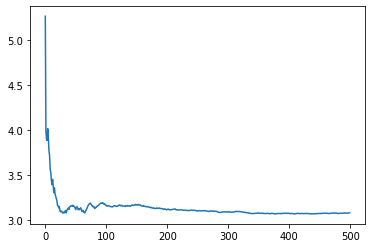

In [9]:
plotbagging() # uncomment and call this function

## Random Forest
If we consider $X_1,\ldots,X_b$ _i.i.d._ of variance $\sigma^2$, we have ${\mathbb{Var}}\left[\frac{1}{b}\sum_{i=1}^b X_i\right]=\frac{\sigma^2}{b}$. Using this fact, the bagging method averages different prediction to reduce the variance of the predicted value. This is done by predicting $\frac{1}{b}\sum_{i=1}^b \mathcal{A}[{B_i}^{S}](x_0)$ instead of predicting $\mathcal{A}[S](x_0)$. However, the variables $\mathcal{A}[{B_i}^{S}](x_0)$ are not independent and they have a correlation coefficient $\rho\geq 0$. Thus, we have that ${\mathbb{Var}}\left[\frac{1}{b}\sum_{i=1}^b \mathcal{A}[{B_i}^{S}](x_0)\right]=\rho \sigma^2+\frac{(1-\rho)}{b}\sigma^2$. 

Intuitively, the ${B_i}^{S}$ bootstrap samples are computed on the same $S$: if the drawn $S$ is different from the "true" distribution then all the bootstrap samples ${B_i}^{S}$ will be similar to $S$ and thus, they will be similarly different from the "true" distribution. 

The idea of the random forest is to reduce the correlation coefficient $\rho$. To do this, the split selection is modified. If we have $p$ explanatory variables, instead of considering the $p$ variables for selecting the best split, we only consider $m$ variables. These $m$ variables are selected randomly among the $p$ variables at each split.

<font color='red'>**Q10:**</font> When $m=p$, to which algorithm the random forest is equivalent ?

<font color='red'>**Q11:**</font> When $m$ decreases, how the variance of the random forest algorithm vary ? Similarly, when $m$ decreases, how the bias of the random forest vary ?

<font color='red'>**Q12:**</font> Write the function `random_forest(X, y, ntrees, m, nmin)` that returns a list of tree models. To grow these trees, each split variable will be selected among a random set of $m$ variables. This set is drawn each time a split has to be selected.

<font color='green'>**Hints for Q12:**</font> To enforce that each split variable will be selected among a random set of $m$ variables, you can specify the $m$ value through the parameter `max_features` of the constructor `sklearn.tree.DecisionTreeRegressor`. The code of the `random_forest` function will be very similar to the `bagging` one.

<font color='blue'>**A10:**</font> Bagging.

<font color='blue'>**A11:**</font> When m decreases the variance reduces (correlation between trees reduces), but the bias increase (the built trees are less "optimal").


In [10]:
def random_forest(X, y, ntrees, m,nmin):
    trees = []
    for _ in range(ntrees):
        Xb, yb = bootstrap(X,y)
        tree = sklearn.tree.DecisionTreeRegressor(max_features=m, min_samples_leaf=nmin, min_samples_split=2*nmin)
        tree.fit(Xb,yb)
        trees.append(tree)
    return trees

# Boosting
_Boosting_ is a family of meta-algorithms. Considering a high bias-low variance learning algorithm $\mathcal{A}$, a _boosting_ meta-algorithm learns a model by combining several models obtained by using $\mathcal{A}$. As opposed to the _bagging_, the $\mathcal{A}$ is applied to a different learning problem at each iteration.

One of the first boosting algorithm is called _AdaBoost_ ([A decision-theoretic generalization of on-line learning and an application to boosting, Y. Freund and R. Schapire, Journal of computer and system sciences, 1997](https://www.cis.upenn.edu/~mkearns/teaching/COLT/adaboost.pdf)). It modifies the weight of each examples at each iteration. Another boosting algorithm, the _gradient boosting_ ([Greedy function approximation: a gradient boosting machine, J. Friedman, Annals of statistics, 2001](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf)), changes the variable to be predicted at each iteration.

Considering a quadratic loss function, the _gradient boosting_ algorithm consists in fitting the residuals at each iteration. The obtained sequence of models $h_1,\ldots,h_n$ are combined to obtain $h$: $h=\mu+\nu \sum_{i=1}^n h_i$ where $\nu \in \left]0;1\right]$ is the _shrinkage_ parameter and $\mu$ is the mean of the variable to predict.


<img src="algoboost.png" width="500">

<font color='red'>**Q13:**</font> The constructor `sklearn.tree.DecisionTreeRegressor(max_depth)` grows a tree with a depth inferior to `max_depth`. This parameter is usually low, leading to a high bias-low variance learning algorithm. Using this constructor, write the function `gradient_boost(X, y, ntrees, nu, max_depth)` that returns a tuple containing $\mu$ and the list of fitted trees.

In [12]:
def gradient_boost(X, y, ntrees, nu, max_depth):
    mu = np.mean(y)
    residuals = y - mu
    trees = []
    for _ in range(ntrees):
        tree = sklearn.tree.DecisionTreeRegressor(max_depth=max_depth)
        tree.fit(X, residuals)
        residuals = residuals - nu * tree.predict(X)
        trees.append(tree)
    return mu, trees

<font color='red'>**Q14:**</font> Write the function `predict_from_gb(mu, nu, trees, X)` that returns the predictions of the gradient boosted model on the input `X`. To compute this prediction you will use the model returned by`gradient_boost`. This model is a tuple containing  $\mu$ and the list of fitted trees. In `predict_from_gb`, these two values are two parameters: `mu` and `trees`.

<font color='green'>**Hints for Q14:**</font> One can start by copy-paste the code in <font color='red'>**Q8**</font> as the obtained code should be quite similar.

In [14]:
def predict_from_gb(mu, nu, trees, X):
    res = mu
    for tree in trees:
        res += nu * tree.predict(X)
    return res

<font color='red'>**Q15:**</font> Execute the code below to plot the RMSE on the validation as a function of the number of trees.

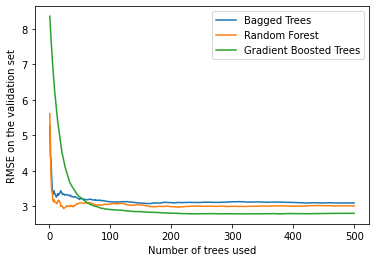

23.71688675880432


In [15]:
import time
X, y = load_data()
Xts, Xvs, yts, yvs = sklearn.model_selection.train_test_split(X, y, random_state=42,train_size =350)

s=time.time()
ntrees = 500
nmin = 1
nu = 0.05
max_depth = 3
m = 9

baggedtrees = bagging(Xts,yts,ntrees,nmin=nmin)
baggedrmses = rmses_from_predictions(predictions_from_trees(mean_predict,baggedtrees,Xvs),yvs)

rftrees = random_forest(Xts,yts,ntrees,m=m,nmin=nmin)
rfrmses = rmses_from_predictions(predictions_from_trees(mean_predict,rftrees,Xvs),yvs)

mu, gbtrees = gradient_boost(Xts, yts, ntrees, nu, max_depth)
def gbpredict(trees,X):
    return predict_from_gb(mu,nu,trees,X)
gbrmses = rmses_from_predictions(predictions_from_trees(gbpredict,gbtrees,Xvs),yvs)


x = np.arange(1,ntrees+1)
for y in [baggedrmses,rfrmses, gbrmses]:
    plt.plot(x, y)
plt.xlabel("Number of trees used")
plt.ylabel("RMSE on the validation set")
plt.legend(('Bagged Trees', 'Random Forest', 'Gradient Boosted Trees'), loc='upper right')
plt.show()
print(time.time()-s)
